In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import tensorflow as tf
import tensorflow.data as tfdata

sys.path.append("../../")

from model.tf.hydro.gr4j_prod import ProductionStorage
from model.tf.ml import LSTM
from utils.training import EarlyStopper
from utils.evaluation import evaluate
from data.tf.utils import read_dataset_from_file, get_station_list

2024-08-20 11:37:28.762870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 11:37:29.624293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 11:37:29.786109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 11:37:29.791837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 11:37:29.863978: I tensorflow/core/platform/cpu_feature_guar

In [3]:
data_dir = '../../data/camels/aus/'
sub_dir = 'no-scale-seq'
station_id = '318076'
run_dir = '../../results/qdeepgr4j-lstm-tf'

window_size = 10

In [4]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 318076


2024-08-20 11:39:55.990836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [5]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds._tensors
t_val, X_val, y_val = val_ds._tensors

y_mu = y_train.numpy().mean(axis=0)
y_sigma = y_train.numpy().std(axis=0)

In [6]:
X_train = tf.keras.ops.nan_to_num(X_train)
X_val = tf.keras.ops.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [7]:
prod_store = ProductionStorage(x1=530.9270033037365)
inp_train = prod_store(X_train, include_x=True)[0]

In [8]:
def create_sequence(X, y, window_size):

        assert window_size is not None, "Window size cannot be NoneType."

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - window_size):
            Xs.append(tf.concat([
                                    X[i: (i + window_size)], 
                                    y[i-1: (i + window_size - 1)]
                                ], axis=1)
                    )
            ys.append(y[i + window_size - 1])

        Xs, ys = tf.stack(Xs), tf.stack(ys)
        # Xs = torch.unsqueeze(Xs, dim=1)

        return Xs, ys

In [9]:
X_train_seq, y_train_seq = create_sequence(inp_train, y_train, 
                                           window_size=window_size)

X_train_seq.shape, y_train_seq.shape

(TensorShape([7436, 10, 10]), TensorShape([7436, 1]))

In [10]:
inp_val = prod_store(X_val, include_x=True)[0]
X_val_seq, y_val_seq = create_sequence(inp_val, y_val, 
                                       window_size=window_size)
X_val_seq.shape, y_val_seq.shape

(TensorShape([3181, 10, 10]), TensorShape([3181, 1]))

In [11]:
train_ds = tfdata.Dataset.from_tensor_slices((X_train_seq, y_train_seq))
train_dl = train_ds.shuffle(buffer_size=1024).batch(batch_size=256)

val_ds = tfdata.Dataset.from_tensor_slices((X_val_seq, y_val_seq))
val_dl = val_ds.shuffle(buffer_size=1024).batch(batch_size=256)

In [13]:
input_dim = 10
hidden_dim = 32
lstm_dim = 64
n_layers = 2
dropout = 0.1


quantiles = [0.05, 0.50, 0.95]
n_quantiles = len(quantiles)

In [14]:
n_epoch = 400
lr = 1e-2

In [15]:

def tilted_loss(y, f):
    quantiles = [0.05, 0.50, 0.95]
    for i, q in enumerate(quantiles):
        e = y - f[:, i]
        if i == 0:
            l = tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
        else:
            l += tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return l

In [16]:
# Compile the model with the Adam optimizer and custom loss function
model = LSTM(input_dim=input_dim,
            hidden_dim=hidden_dim,
            lstm_dim=lstm_dim,
            output_dim=n_quantiles,
            n_layers=n_layers,
            dropout=dropout)
model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.89, beta_2=0.97, weight_decay=0.02),
              loss=tilted_loss)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3)

In [18]:
# Train the model
hist_ = model.fit(X_train_seq, y_train_seq, batch_size=256, shuffle=True, 
          validation_split=0.3, epochs=n_epoch, callbacks=[callback])

Epoch 1/400


2024-08-20 11:44:42.220817: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7325 - val_loss: 0.4393
Epoch 2/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4573 - val_loss: 0.4267
Epoch 3/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4449 - val_loss: 0.4146
Epoch 4/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4368 - val_loss: 0.4166
Epoch 5/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4487 - val_loss: 0.4167
Epoch 6/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4481 - val_loss: 0.4162
Epoch 7/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4489 - val_loss: 0.4137
Epoch 8/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4364 - val_loss: 0.4139
Epoch 9/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4485 - val_loss: 0.4170
Epoch 10/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4538 - val_loss: 0.4108
Epoch 11/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4495 - val_loss: 0.4120
Epoch 12/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4330 - val_l

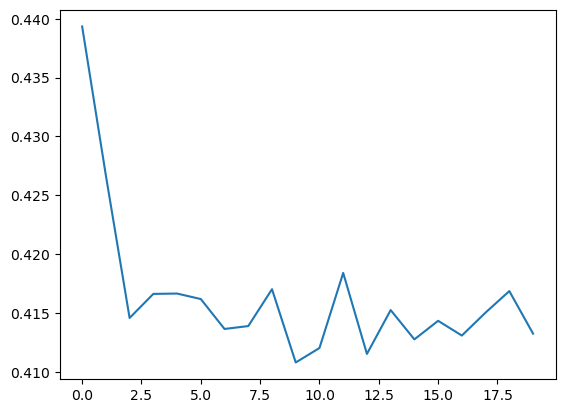

In [19]:
plt.plot(np.arange(len(hist_.history['val_loss'])), np.array(hist_.history['val_loss']))

In [20]:
import tensorflow as tf
import numpy as np

def evaluate_preds(model, ds, batch_size, x_scaler=None, y_scaler=None, quantiles=[0.5]):
    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    # Create a batched dataset
    ds_batched = ds.batch(batch_size)

    for X, y in ds_batched:
        # Predict using the model
        y_hat = model(X)

        # Scale y and y_hat if y_scaler is provided
        if y_scaler is not None:
            y = y_scaler.inverse_transform(y)
            y_hat = y_scaler.inverse_transform(y_hat)

        # Append predictions and true values to the lists
        Q.append(y.numpy())
        Q_hat.append(y_hat.numpy())

        # Inverse transform X if x_scaler is provided
        if x_scaler is not None:
            X_inv = x_scaler.inverse_transform(X[:, -1, :-1])
        else:
            X_inv = X[:, -1, :-1].numpy()
        
        P.append(X_inv[:, 0])
        ET.append(X_inv[:, 1])
    
    # Concatenate all batches
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q = np.concatenate(Q, axis=0).flatten()
    Q_hat = np.clip(np.concatenate(Q_hat, axis=0), 0, None)

    return evaluate(P, ET, Q, Q_hat, quantiles=quantiles)

2024-08-20 11:44:46.625720: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(-3.5762786865234375e-07,
 0.4999999105930488,
 <Figure size 1600x600 with 1 Axes>)

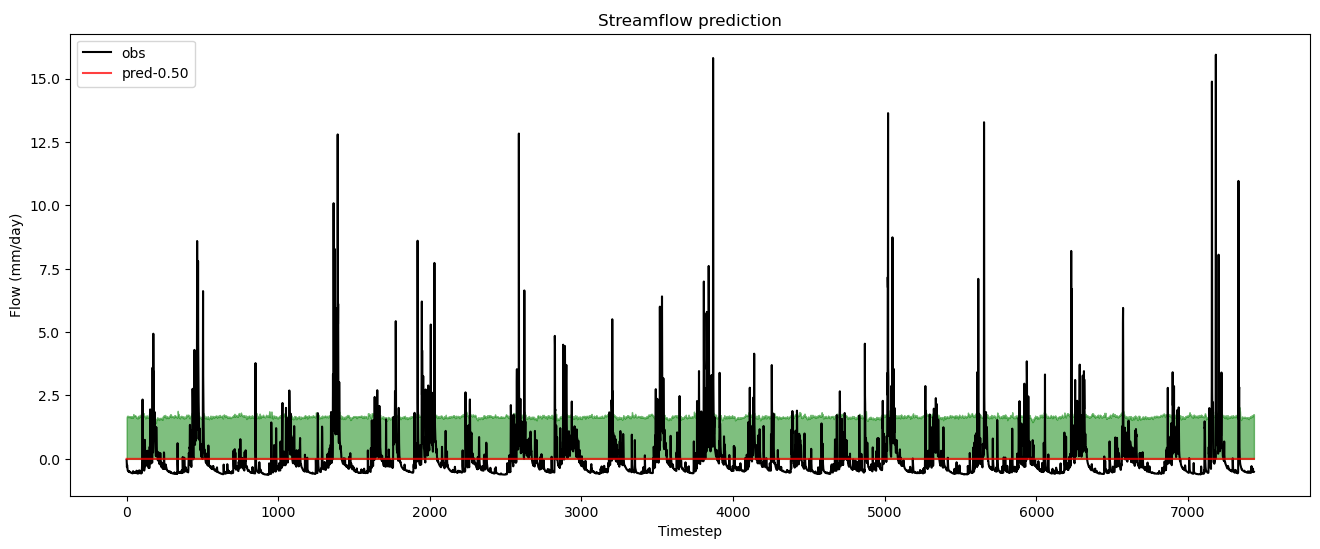

In [21]:
evaluate_preds(model, train_ds, batch_size=256, quantiles=quantiles)

2024-08-20 11:44:46.982803: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(-0.0015380382537841797,
 0.4996157859045422,
 <Figure size 1600x600 with 1 Axes>)

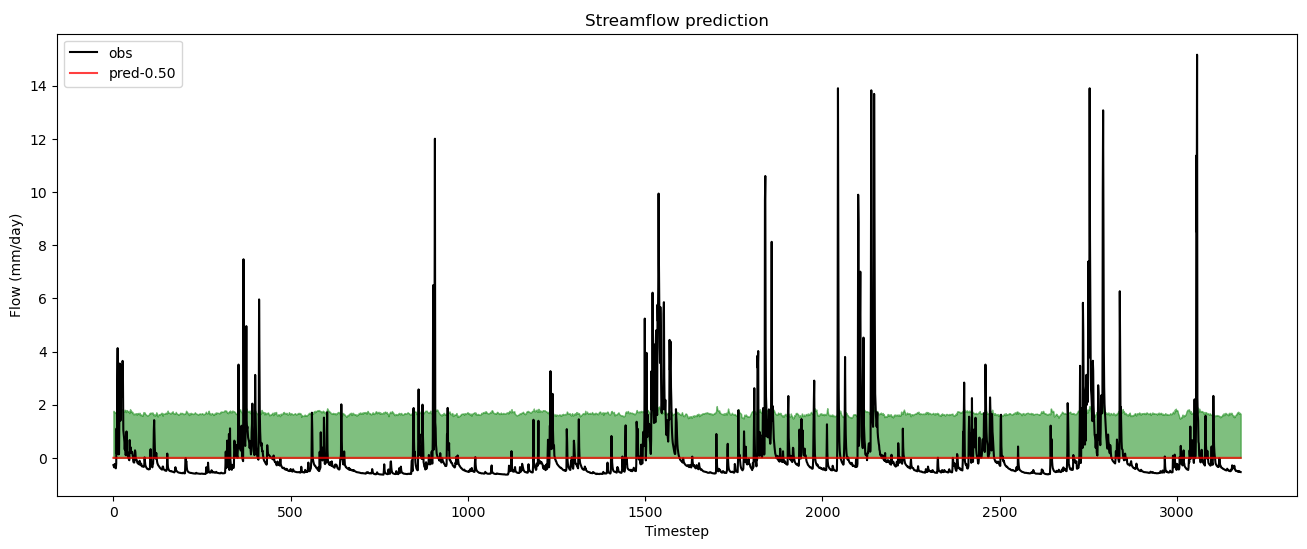

In [22]:
evaluate_preds(model, val_ds, batch_size=256, quantiles=quantiles)